In [1]:
import os
os.environ['DVC_ROOT'] = '..'
import sys
if '..' not in sys.path:
    sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.figure import Figure
from matplotlib.axis import Axis
from matplotlib.collections import PathCollection
import numpy as np
import json
import spacy
from typing import Type

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap.umap_ import UMAP
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import trustworthiness
from sklearn.metrics.pairwise import euclidean_distances

from mock import MagicMock
from unittest.mock import patch

from stages.models.Model import Model
from stages.vectorizers.Vectorizer import Vectorizer
from stages.datacleaners.DataCleaner import DataCleaner
from stages.dataloaders.DataLoader import DataLoader

from stages.datacleaners.DummyDatacleaner import DummyDatacleaner

from stages.dataloaders.PrusVsSienkiewicz import PrusVsSienkiewicz

from stages.vectorizers.BigramMorphTagVectorizer370 import BigramMorphTagVectorizer370

from stages.models.LogisticRegression import LogisticRegression

from stages.models.AffinityPropagation import AffinityPropagation
from stages.models.DBSCAN import DBSCAN
from stages.models.KMeans import KMeans


#https://chat.openai.com/share/c8f1af4b-daef-4065-8ac6-4ff0575c1bcc

2024-04-20 15:38:28.300 | DEBUG    | utils.spacy_gpu:resolve_spacy_batch_size:47 - Spacy: resolved batch size to 500 (default) since NO env var present.


In [10]:
TAGS = {'abbr_yes': 0, 'adptype_post': 1, 'adptype_prep': 2, 'animacy_hum': 3, 'animacy_inan': 4, 'animacy_nhum': 5,
        'aspect_imp': 6, 'aspect_imp,perf': 7, 'aspect_perf': 8, 'case_acc': 9, 'case_dat': 10, 'case_gen': 11,
        'case_ins': 12, 'case_loc': 13, 'case_nom': 14, 'case_voc': 15, 'clitic_yes': 16, 'conjtype_comp': 17,
        'conjtype_oper': 18, 'conjtype_pred': 19, 'degree_cmp': 20, 'degree_pos': 21, 'degree_sup': 22,
        'emphatic_yes': 23, 'foreign_yes': 24, 'gender_fem': 25, 'gender_masc': 26, 'gender_neut': 27, 'hyph_yes': 28,
        'mood_imp': 29, 'mood_ind': 30, 'number[psor]_plur': 31, 'number[psor]_sing': 32, 'number_plur': 33,
        'number_plur,sing': 34, 'number_ptan': 35, 'number_sing': 36, 'numform_digit': 37, 'numform_roman': 38,
        'numform_word': 39, 'numtype_card': 40, 'numtype_ord': 41, 'numtype_sets': 42, 'parttype_int': 43,
        'parttype_mod': 44, 'person_0': 45, 'person_1': 46, 'person_2': 47, 'person_3': 48, 'polarity_neg': 49,
        'polarity_pos': 50, 'polite_depr': 51, 'poss_yes': 52, 'prepcase_npr': 53, 'prepcase_pre': 54,
        'prontype_dem': 55, 'prontype_ind': 56, 'prontype_int': 57, 'prontype_neg': 58, 'prontype_prs': 59,
        'prontype_rel': 60, 'prontype_tot': 61, 'pun_no': 62, 'pun_yes': 63, 'punctside_fin': 64, 'punctside_ini': 65,
        'puncttype_brck': 66, 'puncttype_colo': 67, 'puncttype_comm': 68, 'puncttype_dash': 69, 'puncttype_elip': 70,
        'puncttype_excl': 71, 'puncttype_peri': 72, 'puncttype_qest': 73, 'puncttype_quot': 74, 'puncttype_semi': 75,
        'puncttype_slsh': 76, 'reflex_yes': 77, 'tense_fut': 78, 'tense_past': 79, 'tense_pres': 80, 'variant_long': 81,
        'variant_short': 82, 'verbform_conv': 83, 'verbform_fin': 84, 'verbform_inf': 85, 'verbform_part': 86,
        'verbform_vnoun': 87, 'verbtype_mod': 88, 'verbtype_quasi': 89, 'voice_act': 90, 'voice_pass': 91}

In [11]:
bigrams: list[tuple[str, str]] = sorted(list(set([
            (tag1, tag2)
            for tag1 in TAGS.keys()
            for tag2 in TAGS.keys()
        ])))
len(bigrams)

8464

In [19]:
def calculate_visualisation_metrics(embeddings, embeddings_2d, labels):
    # Davies-Bouldin score
    db_score = davies_bouldin_score(embeddings, labels=labels)

    # Calinski-Harabasz score
    ch_score = calinski_harabasz_score(embeddings, labels=labels)

    # Neighbor preservation
    trustworthiness_score = trustworthiness(embeddings, embeddings_2d, n_neighbors=5)

    # Global structure preservation
    dist_high = euclidean_distances(embeddings)
    dist_low = euclidean_distances(embeddings_2d)
    stress = np.sqrt(((dist_high - dist_low) ** 2).sum()) / np.sqrt((dist_high ** 2).sum())

    return db_score, ch_score, trustworthiness_score, stress

In [20]:
def save_json_results(self, dataset: str, datacleaner: str, vectorizer: str, params_name: str,
                      params: dict[str, str | int | float], metrics: dict[str, float]) -> None:
        dirs_in_path = ["results", dataset, datacleaner, vectorizer, self.__class__.__name__]
        path = '.'
        print(path)

        for p in dirs_in_path:
            path = os.path.join(path, p)
            if not os.path.exists(path):
                os.makedirs(path)

        filename = f"{params_name}.json"
        results = {'params': params, 'metrics': metrics, 'dataset': dataset, 'datacleaner': datacleaner,
                   'vectorizer': vectorizer, 'params_name': params_name}
        with open(os.path.join(path, filename), 'w') as file:
            json.dump(results, file)


def log_clusters_plot(x: np.ndarray, labels: np.ndarray, reduction_method='PCA', data_out=None):
    reducer = get_reducer(reduction_method)
    x_reduced = reducer.fit_transform(x)
    db_score, ch_score, trustworthiness_score, stress = calculate_visualisation_metrics(x, x_reduced, labels=labels)
    if data_out is not None:
         data = {
            'x': x,
            'x_reduced': x_reduced,
            'labels': labels,
            'reduction': reduction_method,
            'db': db_score,
            'ch': ch_score,
            'trustworthiness': trustworthiness_score,
            'stress': stress
         }
         data_out.append(data)

    fig, ax = plt.subplots(figsize=(8, 6))

    for label in np.unique(labels):
        cluster = x_reduced[labels == label]
        ax.scatter(cluster[:, 0], cluster[:, 1], label=str(label), alpha=0.4)
    ax.set_title(f'Clustering\n({reduction_method} reduction)')
    ax.legend()


def get_reducer(name: str):
    reducers = {
        'PCA': PCA(n_components=2),
        'TSNE': TSNE(n_components=2),
        'UMAP': UMAP(n_components=2)
    }
    return reducers[name]


def log_confusion_matrix_plot(conf_matrix: np.ndarray, data_out=None):
    """Plot confusion matrix."""
    if data_out is not None:
         data_out.append(conf_matrix)
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)
    ax.set_title('Macierz pomyłek')
    ax.set_xlabel('przewidziane wartości')
    ax.set_ylabel('poprawne wartości')


X_DATA, Y_DATA = None, None
def log_figure(fig: Figure, path):
     ...

In [21]:
@patch('utils.metrics.classification._log_confusion_matrix_plot')
@patch('utils.metrics.clusterization._log_clusters_plot')
@patch('utils.mlflow.experiments.mlflow_context')
@patch('utils.mlflow.experiments._resolve_experiment_id')
@patch('utils.mlflow.experiments._zip_mlflow_output')
@patch('utils.mlflow.experiments.mlflow')
@patch('utils.metrics.clusterization.mlflow')
@patch('utils.metrics.classification.mlflow')
def run(
    ModelType: Type[Model],
    dataset: DataLoader,
    datacleaner: DataCleaner,
    vectorizer: Vectorizer,
    params_name: str,
    params: dict[str, str | int | float],
    clas_mlflow_patch: MagicMock, 
    clus_mlflow_patch: MagicMock, 
    exp_mlflow_patch: MagicMock,
    zip_mlflow_output_patch: MagicMock,
    resolve_experiment_id_patch: MagicMock, 
    mlflow_context_patch: MagicMock, 
    lcp_patch: MagicMock, 
    lcm_patch: MagicMock
) -> list[np.ndarray]:
    clus_mlflow_patch.log_figure = log_figure
    clas_mlflow_patch.log_figure = log_figure
    results = []
    lcp_patch.side_effect = lambda x, labels, reduction_method: log_clusters_plot(x, labels, reduction_method, results)
    lcm_patch.side_effect = lambda conf_matrix: log_confusion_matrix_plot(conf_matrix, results)
    ModelType.save_json_results = save_json_results
    ModelType.save_mlflow_results = MagicMock()
    kmeans = ModelType()
    kmeans.evaluate(dataset.__class__.__name__, datacleaner.__class__.__name__, vectorizer.__class__.__name__, params_name, params)
    return results

2024-04-10 10:57:29.495 | WARNING  | utils.spacy_gpu:autoconfigure_spacy_mode:36 - Environment variable GRE_SPACY_MODE not set - defaulting to 'cpu'
2024-04-10 10:57:29.498 | INFO     | utils.spacy_gpu:_use_cpu:53 - Spacy: using CPU
2024-04-10 10:57:30.811 | INFO     | stages.models.DBSCAN:evaluate:17 - Fitting DBSCAN...
2024-04-10 10:57:31.635 | INFO     | utils.metrics.clusterization:compute_clustering_metrics:27 - Preparing plots...
2024-04-10 10:57:59.011 | INFO     | utils.metrics.clusterization:compute_clustering_metrics:31 - Clustering metrics: silhouette: 0.05708409745685584 davies_bouldin: 5.566687992140141 calinski_harabasz: 171.39694216558763
2024-04-10 10:58:23.842 | INFO     | utils.metrics.clusterization:compute_b_cubed_metrics:47 - B-Cubed metrics: bcubed_precission: 0.50544681735577 bcubed_recall: 0.5657412886029651 bcubed_f1: 0.5338971412778859


.


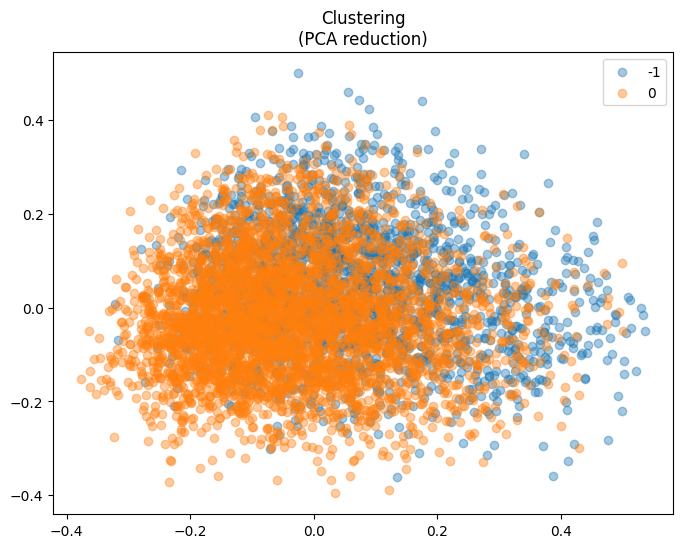

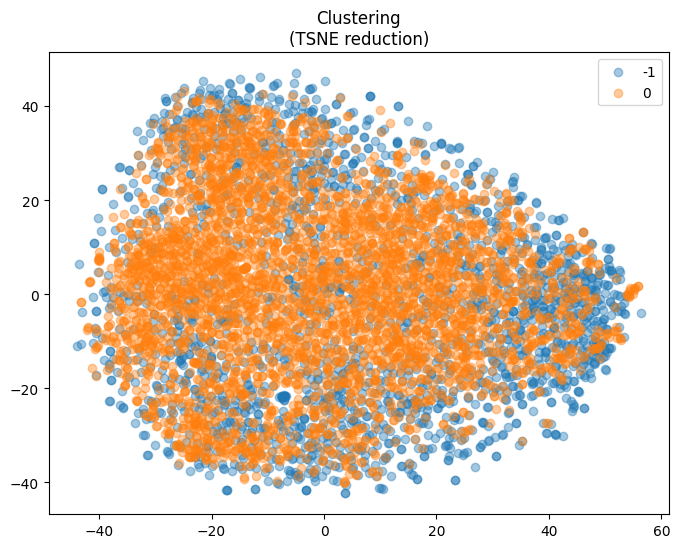

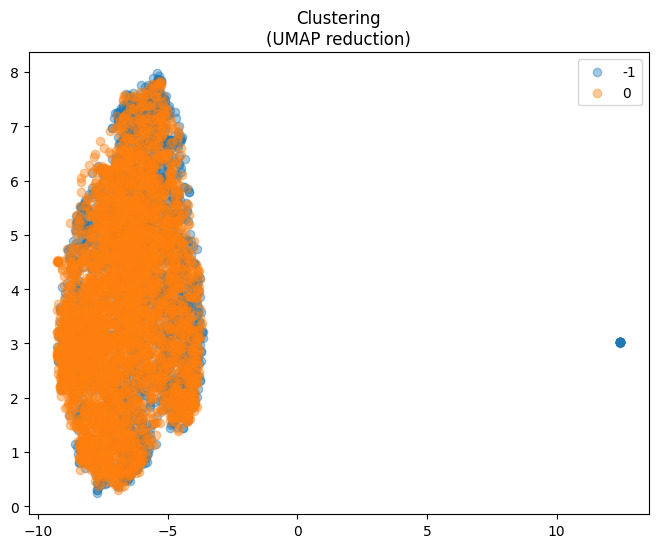

In [22]:
res = run(
    DBSCAN,
    PrusVsSienkiewicz(),
    DummyDatacleaner(),
    BigramMorphTagVectorizer370(),
    'DBSCAN',
    {}
)

In [23]:
for elem in res:
    print(elem)

{'x': array([[ 0.40975879,  0.1068657 ,  0.19093409, ...,  0.00194554,
         0.01244727, -0.00266663],
       [ 0.27262546,  0.20756379,  0.08553658, ..., -0.00369111,
        -0.00614525,  0.00304785],
       [ 0.34658857,  0.00099772,  0.16452144, ..., -0.00416919,
         0.00395378, -0.00975933],
       ...,
       [ 0.3388965 ,  0.02745944, -0.15106492, ...,  0.00078996,
         0.00074632,  0.00422722],
       [ 0.15700626, -0.11022974,  0.01463797, ..., -0.00509549,
        -0.00864398,  0.00488289],
       [ 0.01954144, -0.11203038, -0.02800857, ...,  0.00108022,
        -0.0058849 , -0.00473132]]), 'x_reduced': array([[ 0.40975886,  0.10686617],
       [ 0.27262526,  0.20756276],
       [ 0.34658868,  0.00099843],
       ...,
       [ 0.33889633,  0.02745861],
       [ 0.15700645, -0.11022894],
       [ 0.01954141, -0.11203065]]), 'labels': array([-1,  0,  0, ..., -1,  0,  0], dtype=int64), 'reduction': 'PCA', 'db': 5.566687992140141, 'ch': 171.39694216558763, 'trustworth

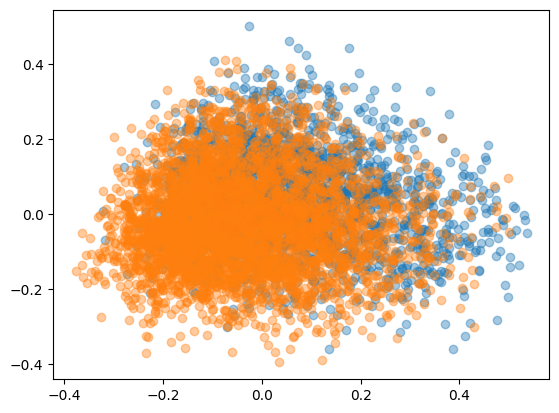

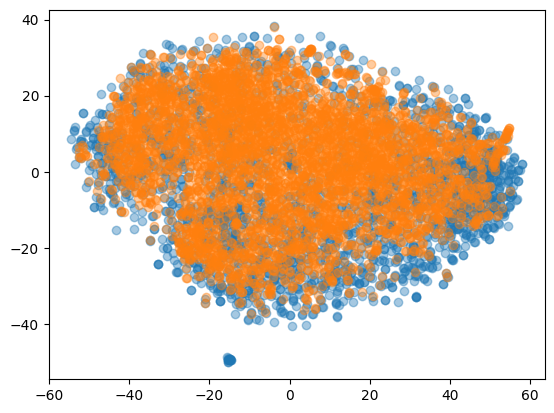

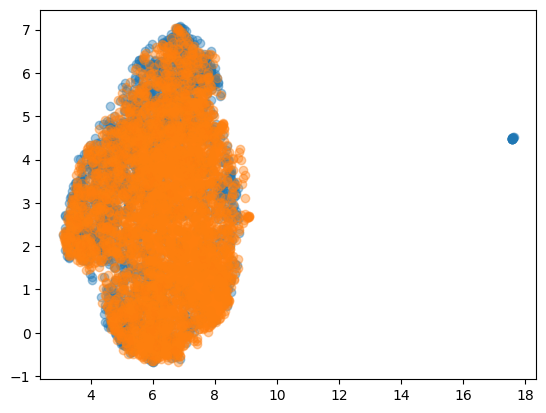

In [5]:
for data, labels in zip(res[::2], res[1::2]):
    for label in np.unique(labels):
        cluster = data[labels == label]
        plt.scatter(cluster[:, 0], cluster[:, 1], label=str(label), alpha=0.4)
    plt.show()

2024-04-10 10:46:42.780 | WARNING  | utils.spacy_gpu:autoconfigure_spacy_mode:36 - Environment variable GRE_SPACY_MODE not set - defaulting to 'cpu'
2024-04-10 10:46:42.783 | INFO     | utils.spacy_gpu:_use_cpu:53 - Spacy: using CPU
2024-04-10 10:46:44.037 | INFO     | stages.models.LogisticRegression:evaluate:21 - Fitting Logistic Regression classifier...
2024-04-10 10:46:44.038 | DEBUG    | stages.models.LogisticRegression:evaluate:22 - {}
2024-04-10 10:46:44.834 | INFO     | stages.models.LogisticRegression:evaluate:26 - Running predict...
2024-04-10 10:46:44.836 | INFO     | utils.metrics.classification:compute_classification_metrics:26 - Calculating metrics...
2024-04-10 10:46:44.872 | INFO     | utils.metrics.classification:compute_classification_metrics:52 - Result metrics: F1 = 0.697


.


[array([[208,  91],
        [170, 461]], dtype=int64)]

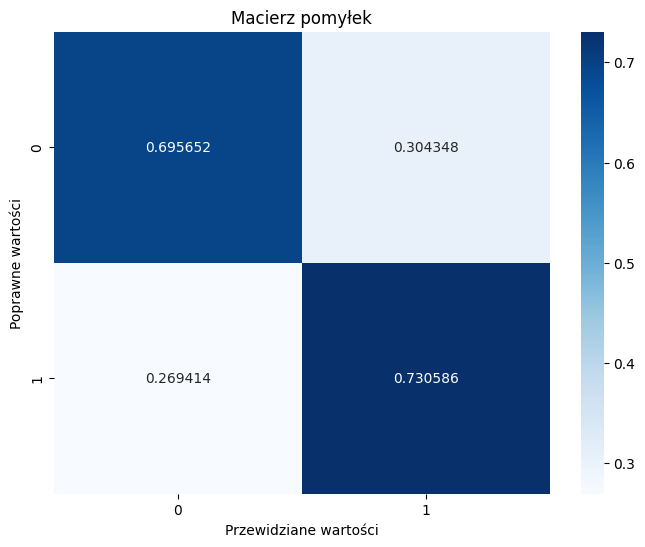

In [10]:
res = run(
    LogisticRegression, 
    PrusVsSienkiewicz(), 
    DummyDatacleaner(), 
    BigramMorphTagVectorizer370(), 
    'logistic', 
    {}
)
res

In [ ]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics.pairwise import cosine_similarity

# Compute pairwise distances/similarities in the high-dimensional space
dist_high = euclidean_distances(embeddings)

# Compute pairwise distances/similarities in the lower-dimensional embedding
dist_low = euclidean_distances(embeddings_2d)

# Calculate correlation coefficients for different measures
pearson_corr, _ = pearsonr(dist_high.ravel(), dist_low.ravel())
spearman_corr, _ = spearmanr(dist_high.ravel(), dist_low.ravel())
cosine_sim = cosine_similarity(dist_high, dist_low).mean()

# Choose the best correlation measure
best_measure = max(pearson_corr, spearman_corr, cosine_sim)

# Use the best measure to quantify global structure preservation
if best_measure == pearson_corr:
    global_structure_preservation = pearson_corr
    print("Using Pearson correlation coefficient.")
elif best_measure == spearman_corr:
    global_structure_preservation = spearman_corr
    print("Using Spearman rank correlation coefficient.")
else:
    global_structure_preservation = cosine_sim
    print("Using cosine similarity.")

print("Global Structure Preservation:", global_structure_preservation)